In [1]:
pip install "numpy<2.0" --upgrade

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

data = np.load("../data/all_imagesfinal.npz")

print(data.files)


['all_imagesfinal']


In [3]:
images = data["all_imagesfinal"]
print(images.shape)


(131057, 32, 32)


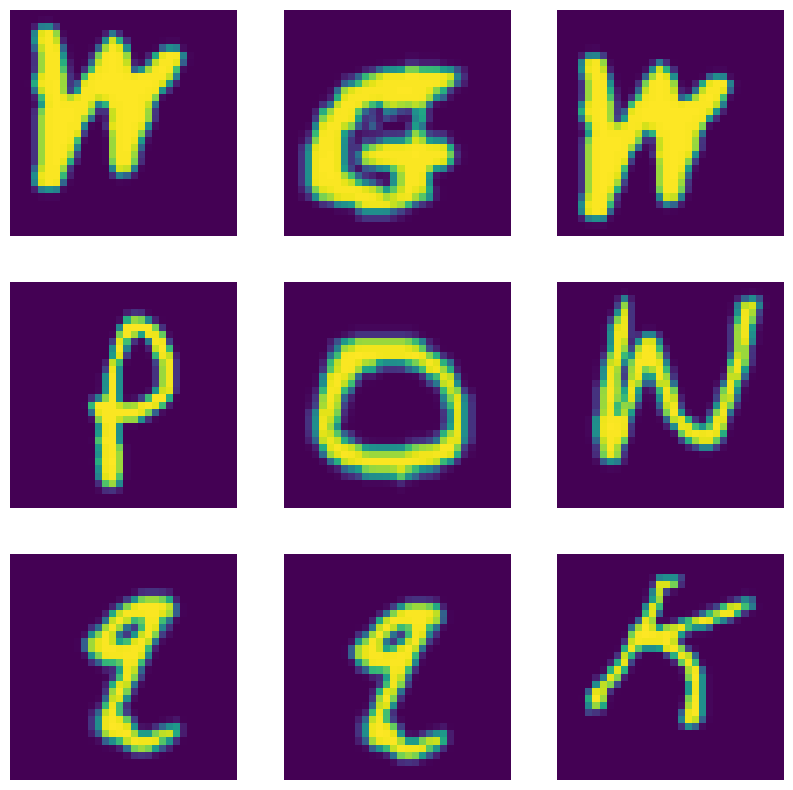

In [4]:
#pour voir quelques images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# **Partie 1: Anomaly detection on corrupted EMNIST**

## 1. Altered EMNIST
D'abord, on va chercher a comprendre comment ont été altérées les images du datset pour mieux comprendre notre sujet:

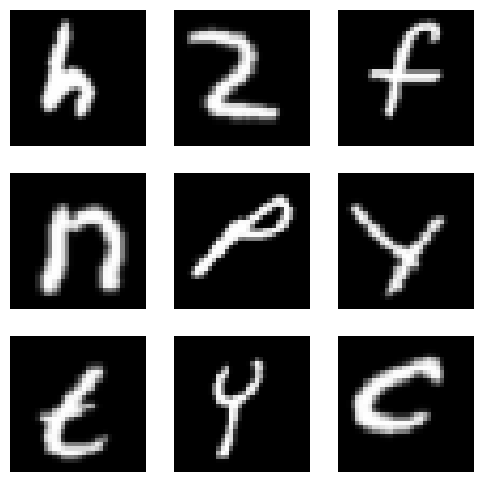

In [5]:
#9 images aleatoires

fig, axes = plt.subplots(3, 3, figsize=(6,6))
for ax in axes.flatten():
    idx = np.random.randint(len(images))
    ax.imshow(images[idx], cmap="gray")
    ax.axis("off")
plt.show()



En observant plusieurs échantillons du dataset EMNIST corrompu, on remarque que les lettres conservent leur structure globale (ce qui signifie une transformation partielle seulement solon moi).

Cependant, elles présentent souvent un aspect inhabituel. Certaines images sont floues, d’autres montrent des traits très fins ou au contraire légèrement épaissis. Plusieurs caractères semblent déformés, comme étirés ou écrasés, ce qui suggère une altération géométrique. 

On ne voit pas de bruit clair, ni de rotation systématique ou de patchs masqués. L’ensemble de ces observations indique que le dataset a probablement subi une forme de floutage (gaussien ou directionnel) et/ou une érosion qui modifie l’épaisseur des traits des lettres.

c'est ce qu'on va chercher a comprendre :

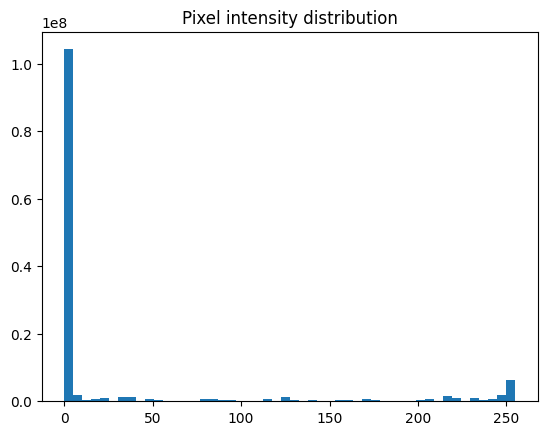

In [6]:
#l’histogramme des pixels pour voir des modifications globales du contraste/du flou...
plt.hist(images.flatten(), bins=50)
plt.title("Pixel intensity distribution")
plt.show()


Même si un pic à 0 est normal à cause du fond noir, on observe ici très peu de niveaux de gris intermédiaires(20-200), ce qui suggère une perte de détails dans les contours.

typique d’un floutage ou d’un lissage ?

In [7]:
print("min pixel:", images.min())
print("max pixel:", images.max())
print("mean pixel:", images.mean())



from scipy.ndimage import laplace
import numpy as np

def sharpness(img):
    return np.mean(np.abs(laplace(img)))

for i in range(5):
    idx = np.random.randint(len(images))
    print("Image", idx, "sharpness =", sharpness(images[idx]))




min pixel: 0.0
max pixel: 255.0
mean pixel: 34.232854690191644
Image 35354 sharpness = 45.62109375
Image 71935 sharpness = 30.04296875
Image 10714 sharpness = 26.931640625
Image 27338 sharpness = 50.828125
Image 38883 sharpness = 35.087890625


In [8]:
sharpness_values = [sharpness(img) for img in images]

print("min sharpness:", np.min(sharpness_values))
print("max sharpness:", np.max(sharpness_values))
print("mean sharpness:", np.mean(sharpness_values))
print("median sharpness:", np.median(sharpness_values))


min sharpness: 7.6796875
max sharpness: 413.876953125
mean sharpness: 32.048882623543534
median sharpness: 30.798828125


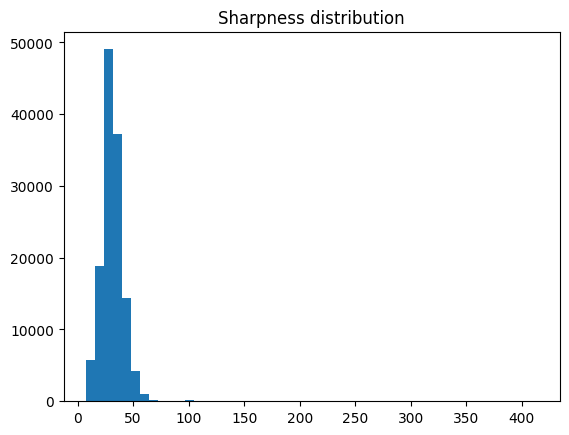

In [9]:
plt.hist(sharpness_values, bins=50)
plt.title("Sharpness distribution")
plt.show()


ok, on voit ici que la distribution de netteté est fortement concentrée entre 20-60, avec une moyenne autour de 32 (mean sharpness: 32.048).

Ces valeurs sont significativement plus faibles que celles attendues pour des lettres manuscrites normales, ce qui indique une forte perte de détails dans les contours.

 L'histogramme, très resserré, montre que cette baisse de netteté concerne presque toutes les images, ce qui suggère que le dataset a subi **une corruption globale de type floutage ou lissage systématique**.

## 2. Unsupervised anomaly detection 
Comme vu en cours, on va maintenant proceder a un AE (autoencoder) pour l'anomaly detection et ainsi identifier les images corrompues

si j'ai bien compris, l’autoencoder apprend à reconstruire les images “normales” du dataset et échoue davantage sur celles qui sont fortement corrompues.
L’erreur de reconstruction devient donc un score d’anomalie permettant d’identifier automatiquement les images les plus dégradées ou atypiques.

#### A-Entrainement de l'AE sur les images corrompues:

In [10]:
#pip install torch

In [11]:
#pip install "numpy<2.0" --upgrade


In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

#normalisation en 0-1
x = torch.tensor(images / 255., dtype=torch.float32)

#le modèle attend un canal (131057, 1, 32, 32) ?
x = x.unsqueeze(1)

dataset = TensorDataset(x, x)
loader = DataLoader(dataset, batch_size=128, shuffle=True)


In [13]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 64)  # latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 32*32),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 32, 32)


In [14]:
#entrainement de l'ae
model = AE()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for batch, _ in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"n° {epoch+1}, loss = {total_loss / len(loader):.6f}")
        

n° 1, loss = 0.026422
n° 2, loss = 0.009379
n° 3, loss = 0.006950
n° 4, loss = 0.005841
n° 5, loss = 0.005126
n° 6, loss = 0.004680
n° 7, loss = 0.004380
n° 8, loss = 0.004185
n° 9, loss = 0.004054
n° 10, loss = 0.003921


on cherche a minimiser l’erreur de reconstruction (MSE):

Si l’image est étrange (floue/distordue), le modèle n’arrive pas à la reconstruire correctement -> erreur élevée.

Maintenant, on a un 1er modèle, \
Pour chaque image, on calcule l’erreur de reconstruction moyenne: \
Plus l’erreur est grande → plus l’image est "anormale"

In [15]:
with torch.no_grad():
    recon_all = model(x).cpu().numpy()

errors = ((recon_all - x.cpu().numpy())**2).mean(axis=(1,2,3))


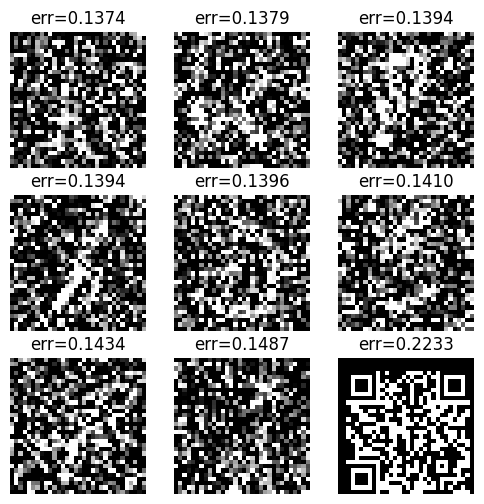

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Top9 images avec plus grande erreur:
idx_sorted = np.argsort(errors)[-9:]

fig, axes = plt.subplots(3, 3, figsize=(6,6))
for ax, idx in zip(axes.flatten(), idx_sorted):
    ax.imshow(images[idx], cmap="gray")
    ax.set_title(f"err={errors[idx]:.4f}")
    ax.axis("off")
plt.show()


effectivement, on voit bien des images avec une grande modification en rapport au dataset initial:

Les images associées aux plus fortes erreurs de reconstruction ne ressemblent plus du tout à des lettres.\
Elles sont extrêmement bruitées, quasi aléatoires, et parfois même complètement aberrantes (ex. QR-code).\
L’autoencoder échoue donc à les reconstruire, ce qui confirme qu’il utilise efficacement l’erreur de reconstruction comme indicateur d’anomalies fortes dans le dataset.

On va essayer de "reconstruire" l'image la + anormale grace a l'AutoEncodeur :

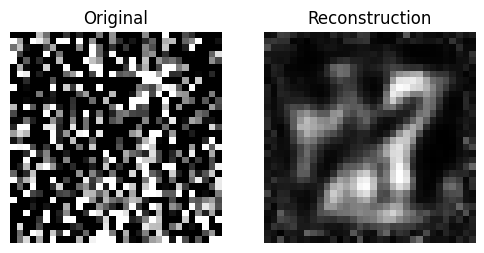

In [19]:
i = idx_sorted[-2]  # la 2eme + anormale

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(images[i], cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(recon_all[i,0], cmap='gray')
plt.title("Reconstruction")
plt.axis("off")
plt.show()


Face à une image entièrement bruitée, l'AE reconstruit une forme floue et incohérente, confirmant qu’il ne peut pas extraire de structure valide et que cette image est une anomalie majeure.

### Conclusion AutoEncodeur :
L’autoencoder apprend à reconstruire les lettres typiques du dataset, mais il échoue dès que l’image est trop floue, déformée ou totalement bruitée. Les erreurs de reconstruction obtenues servent donc naturellement de scores d’anomalie : les images les plus altérées présentent les erreurs les plus élevées. Cette étape confirme que le modèle capture bien la structure des lettres normales et met en évidence les corruptions présentes dans le dataset.

### B-PCA pour Anomaly Detection

In [20]:
from sklearn.decomposition import PCA

#normalisation 0-1
flat = images.reshape(len(images), -1) / 255.0

#Réduction de dimension
pca = PCA(n_components=50)
proj = pca.fit_transform(flat)
recon_pca = pca.inverse_transform(proj)



on fait une recinstruction PCA :\
Reconstruction PCA = image compressée puis reconstruite

Les images normales seront bien reconstruites mais les anomalies seront très mal reconstruites

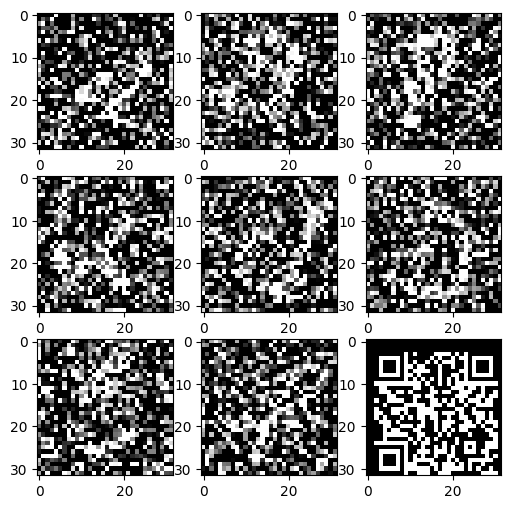

In [21]:
# score d'anomalie
errors_pca = ((flat - recon_pca)**2).mean(axis=1)

# Top 9 images avec plus grande erreur
idx_sorted = np.argsort(errors_pca)[-9:]

fig, axes = plt.subplots(3, 3, figsize=(6,6))
for ax, idx in zip(axes.flatten(), idx_sorted):
    ax.imshow(images[idx], cmap="gray")

Les images ayant la plus forte erreur PCA sont presque identiques à celles détectées par l’autoencoder

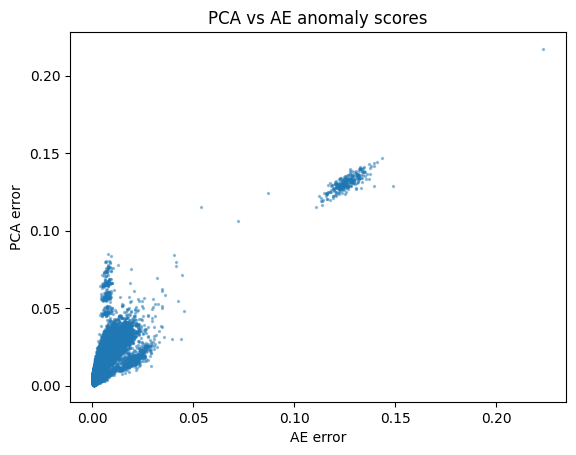

In [22]:
#on compare pca et AE :
plt.scatter(errors, errors_pca, s=2, alpha=0.4)
plt.xlabel("AE error")
plt.ylabel("PCA error")
plt.title("PCA vs AE anomaly scores")
plt.show()


Le nuage de points montre une forte corrélation entre l’erreur **PCA** et l’erreur de **l’autoencoder** : les images que l’un juge anormales sont également repérées par l’autre. On observe deux groupes distincts : un grand cluster avec de faibles erreurs (images normales) et un petit cluster avec des erreurs beaucoup plus élevées (images très corrompues ou bruitées). 

Ce résultat confirme que les deux méthodes détectent les mêmes anomalies structurelles dans le dataset et se renforcent mutuellement.

### Conclusion PCA :
PCA détecte les mêmes anomalies que l’autoencoder, confirmant la présence d’images fortement corrompues et la cohérence des deux méthodes.

On va maintenant chercher à identifier officiellement la corruption:

# 3. Recovering the corrupted dataset

Selon les cas: recuperables vs irrecuperables, on va adopter 2 strategies differentes (en fonction des erreurs AE ou PCA):


In [ ]:
threshold = np.percentile(errors, 99)  # top 1% anomalies
recoverable = images[errors < threshold]
unrecoverable = images[errors >= threshold]

#3.2


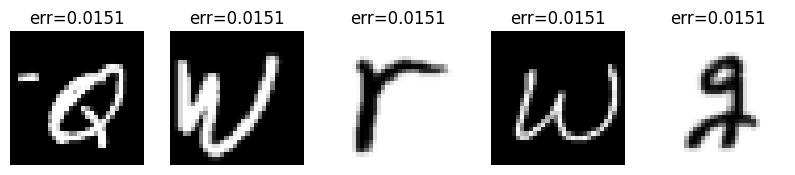

In [ ]:
#on visualise les 5 images les plus anormales restantes:

threshold = np.percentile(errors, 99)
mask_recoverable = errors < threshold
errors_recoverable = errors[mask_recoverable]
indices_recoverable = np.where(mask_recoverable)[0]
top5_indices_local = np.argsort(errors_recoverable)[-5:]  # indices dans le tableau filtered
top5_indices_global = indices_recoverable[top5_indices_local]  # indices dans le dataset original
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for ax, idx in zip(axes, top5_indices_global):
    ax.imshow(images[idx], cmap="gray")
    ax.set_title(f"err={errors[idx]:.4f}")
    ax.axis("off")
plt.show()




Les images restantes sont reconnaisables, on va passser au défloutage et a la reconstruction :

In [27]:
pip install scikit-image

Python(34982) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.1 MB 16.7 MB/s eta 0:00:01   |██████████████▋                 | 6.4 MB 5.5 MB/s eta 0:00:02
     |████████████████████████████████| 317 kB 30.8 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 20.6 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from skimage.filters import unsharp_mask

def deblur(img):
    return unsharp_mask(img, radius=1.5, amount=1.2)
recovered = np.array([deblur(img) for img in recoverable])

#ici, on a les images défloutées et reconstruites


On pourrait aussi utiliser la sortie de l’AE comme image restaurée:

In [29]:
with torch.no_grad():
    ae_recon = model(x).cpu().numpy()[:, 0]  # (N, 32, 32)
final_dataset = images.copy()
final_dataset[errors < threshold] = (ae_recon[errors < threshold] * 255).astype(np.uint8)


On va tester plusieurs méthodes de restauration sur 5 images différentes:

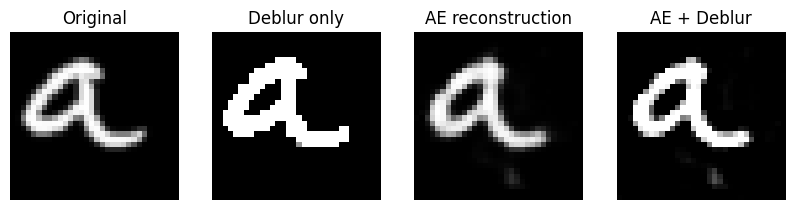

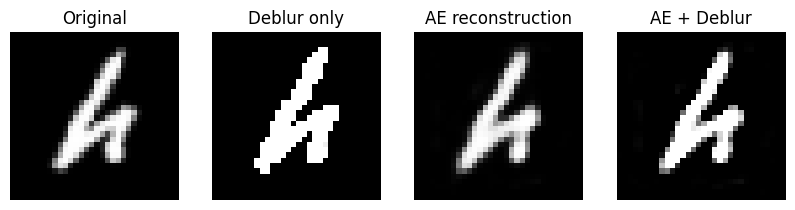

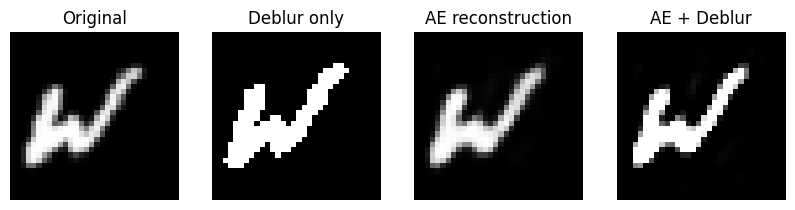

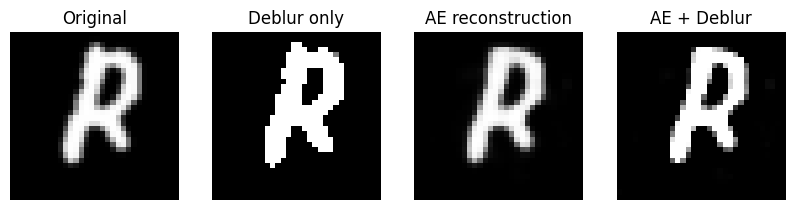

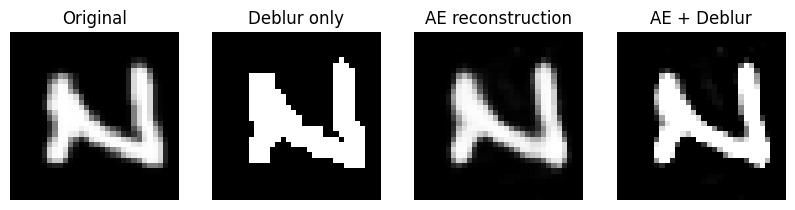

In [ ]:
#on prend 5 images recoverable
idx = np.random.choice(np.where(errors < threshold)[0], 5)

for i in idx:
    original = images[i]                    
    ae_img = ae_recon[i]         
    deblur_only = deblur(original)
    ae_plus_deblur = deblur(ae_img)
    
    plt.figure(figsize=(10,3))
    
    # 1. Image Originale
    plt.subplot(1,4,1)
    plt.imshow(original, cmap="gray")
    plt.title("Original")
    plt.axis("off")
    
    # 2. Déblur seulement
    plt.subplot(1,4,2)
    plt.imshow(deblur_only, cmap="gray")
    plt.title("Deblur only")
    plt.axis("off")
    
    # 3. AE reconstruction
    plt.subplot(1,4,3)
    plt.imshow(ae_img, cmap="gray")
    plt.title("AE reconstruction")
    plt.axis("off")
    
    # 4. AE + Déblur
    plt.subplot(1,4,4)
    plt.imshow(ae_plus_deblur, cmap="gray")
    plt.title("AE + Deblur")
    plt.axis("off")
    
    plt.show()


Pour restaurer les images corrompues, on a testé 3 stratégies différentes:\
1- un filtrage classique basé sur la netteté\
2- la reconstruction par autoencoder\
3- une combinaison des deux méthodes

1. Déblur only:\
Cette méthode renforce artificiellement les contours en accentuant les transitions de pixels.\
Visuellement, elle améliore légèrement la netteté, mais ne permet pas de corriger la structure globale de la lettre : les artefacts et irrégularités du flou restent présents, et les traits deviennent parfois trop épais ou “bouchés”. Cette approche seule ne suffit donc pas à restaurer fidèlement les caractères selon moi.

2. AE reconstruction:\
L’autoencoder, entraîné sur l’ensemble du dataset, apprend une représentation latente “propre” de ce à quoi une lettre EMNIST devrait ressembler. Si on lui fournit une image floue, il est sensé en génèrer une version plus régulière et mieux formée (meme si ici c'est assez discutable).\
C’est d'ailleurs pour ca que la sortie de l’AE ressemble fortement à l’original : le modèle reconstruit une lettre plausible et débruitée. Cette capacité à “deviner” la lettre la plus probable à partir d’une entrée dégradée explique pourquoi la reconstruction est si proche visuellement.

3. AE + Déblur :\
La combinaison des deux approches donne, pour moi, le meilleur résultat. L’AE produit une image propre mais un peu lissée, et le déblur applique ensuite un renforcement local des contours. L’image finale est plus nette tout en conservant la structure correcte générée par l’AE. Cette méthode constitue donc une bonne solution pour reconstruire des lettres floues ou érodées.

L’AE reconstruit la forme correcte des lettres, tandis que le déblur améliore ensuite leur netteté, ce qui en fait une combinaison pertinente pour restaurer un dataset corrompu par du flou ou une perte d’épaisseur

# 4- Evaluation

Dernière étape, on va mesurer si nos méthodes de reconstruction améliorent la qualité des images recoverable:

In [32]:
#MSE avant et apres

def mse(a, b):
    return ((a - b) ** 2).mean()

mse_ae = []
mse_deblur = []
mse_combo = []

for i in np.where(errors < threshold)[0]:   #recoverable
    orig = images[i] / 255
    ae_img = ae_recon[i]
    deblur_img = deblur(images[i])
    combo_img = deblur(ae_recon[i])
    
    mse_ae.append(mse(orig, ae_img))
    mse_deblur.append(mse(orig, deblur_img))
    mse_combo.append(mse(orig, combo_img))

print("MSE AE reconstruction:", np.mean(mse_ae))
print("MSE Deblur only:", np.mean(mse_deblur))
print("MSE AE + Deblur:", np.mean(mse_combo))


MSE AE reconstruction: 0.0034191208155110223
MSE Deblur only: 0.02272865376236101
MSE AE + Deblur: 0.0071656639923618325


ok maintenant, on va tester la similarité structurelle (contraste, texture...) avec SSIM:

In [33]:
from skimage.metrics import structural_similarity as ssim

ssim_ae = []
ssim_deblur = []
ssim_combo = []

for i in np.where(errors < threshold)[0]:
    orig = images[i] / 255
    ae_img = ae_recon[i]
    deblur_img = deblur(images[i])
    combo_img = deblur(ae_recon[i])

    ssim_ae.append(ssim(orig, ae_img, data_range=1.0))
    ssim_deblur.append(ssim(orig, deblur_img, data_range=1.0))
    ssim_combo.append(ssim(orig, combo_img, data_range=1.0))

print("SSIM AE reconstruction:", np.mean(ssim_ae))
print("SSIM Deblur only:", np.mean(ssim_deblur))
print("SSIM AE + Deblur:", np.mean(ssim_combo))


SSIM AE reconstruction: 0.911522830384007
SSIM Deblur only: 0.834883763857786
SSIM AE + Deblur: 0.880605643720312


In [34]:
#on compare ici la netteté:
def sharpness(img):
    gy, gx = np.gradient(img)
    return (gx**2 + gy**2).mean()

sharp_orig = []
sharp_ae = []
sharp_deblur = []
sharp_combo = []

for i in np.where(errors < threshold)[0]:
    orig = images[i] / 255
    ae_img = ae_recon[i]
    deblur_img = deblur(images[i])
    combo_img = deblur(ae_recon[i])
    
    sharp_orig.append(sharpness(orig))
    sharp_ae.append(sharpness(ae_img))
    sharp_deblur.append(sharpness(deblur_img))
    sharp_combo.append(sharpness(combo_img))

print("Sharpness original:", np.mean(sharp_orig))
print("Sharpness AE:", np.mean(sharp_ae))
print("Sharpness Deblur:", np.mean(sharp_deblur))
print("Sharpness AE + Deblur:", np.mean(sharp_combo))

Sharpness original: 0.03243411859866273
Sharpness AE: 0.028592438
Sharpness Deblur: 0.05790234741345051
Sharpness AE + Deblur: 0.04422164


Enfin, on teste la qualité des erreurs de chaque modèle car si la qualité globale s’améliore, la moyenne des erreurs AE devrait baisser:

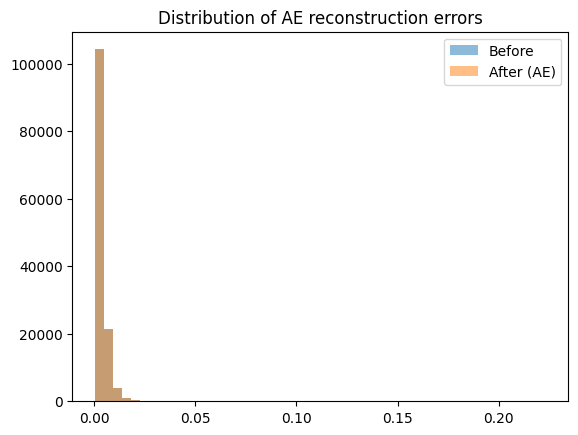

In [35]:
errors_after = ((ae_recon - images/255) ** 2).mean(axis=(1,2))

plt.hist(errors, bins=50, alpha=0.5, label="Before")
plt.hist(errors_after, bins=50, alpha=0.5, label="After (AE)")
plt.legend()
plt.title("Distribution of AE reconstruction errors")
plt.show()


Nous avons évalué trois stratégies de restauration (déblur seul, reconstruction par autoencoder, combinaison AE + déblur) au moyen de métriques entièrement non supervisées. Les résultats montrent que **l’autoencoder** est la méthode la plus efficace pour corriger le flou et les dégradations.

En effet : il obtient la plus faible erreur de reconstruction (MSE = 0.0034) et la meilleure similarité structurelle (SSIM = 0.91), indiquant qu’il parvient à reproduire fidèlement la forme des lettres.

**Le déblur** seul augmente la netteté mais dégrade la structure du caractère (MSE élevée, SSIM plus faible), ce qui confirme qu’un filtrage isolé n’est pas suffisant.

**La combinaison AE + déblur** améliore la netteté tout en conservant une reconstruction correcte (sharpness plus haute que l’AE seul, SSIM = 0.88), mais reste légèrement moins performante que l’autoencoder pur en termes de fidélité globale.

Ainsi, les métriques quantitatives confirment que l’autoencoder fournit la meilleure restauration globale, et que l’option AE + déblur constitue un compromis intéressant lorsque l’on souhaite des contours plus nets.

# **Partie 2: Explore Mode collapse for training a GAN on MNIST**

# 1 — Chargement de MNIST

### Ce que tu dois faire :

-Charger MNIST mais ne jamais utiliser les labels.

-Normaliser les images (0–1 ou -1–1 selon architecture).

-Afficher quelques échantillons pour montrer que tout est cohérent.

### Ce qu’on attend dans le notebook :

-Quelques visuels → 25 images MNIST.

-Phrase rappelant que l’apprentissage est strictement non supervisé.

# 2 — Entrainer un GAN vanilla sur MNIST

### Objectifs :

Construire un GAN simple (MLP ou DCGAN très léger).

Montrer une première génération correcte.

Identifier s’il y a déjà du mode collapse ou non.

### Ce qu’on attend :

Explication très simple :
le générateur apprend à produire des images ressemblant à MNIST ; le discriminant apprend à distinguer vrai/faux.

Affichage de :

    * quelques batchs générés au début

    * quelques batchs générés à la fin

    * évolution des losses (G & D)

# 3. Provoquer volontairement du mode collapse

L’objectif est d’entraîner un GAN dans des conditions qui favorisent le mode collapse, afin d’observer le phénomène et de comprendre ses causes. Plusieurs stratégies peuvent être utilisées pour provoquer volontairement un collapse :

Utiliser un seed défavorable qui rend l’entraînement instable.

Réduire la capacité du générateur (réseau trop simple).

Augmenter le learning rate.

Entraîner le GAN trop longtemps, ce qui déséquilibre le jeu entre G et D.

Choisir une architecture mal adaptée ou trop petite.

Ce qu’il faut montrer :

Des échantillons générés qui deviennent identiques ou presque.

Un exemple typique est lorsque le modèle ne génère plus qu’un seul chiffre ou une seule forme.

L’évolution des pertes (G et D) pendant le collapse, montrant un déséquilibre progressif.

Analyse à fournir :

Le générateur finit par converger vers une solution triviale consistant à produire un seul mode, car cette sortie trompe suffisamment bien le discriminant. Le discriminant, trop fort ou trop faible, ne fournit plus un signal d’apprentissage varié. Le jeu adversarial se déséquilibre, ce qui conduit à l’effondrement des modes.

# 4. Solutions pour limiter le mode collapse

Pour corriger ou atténuer le mode collapse, plusieurs techniques peuvent être testées. Il est recommandé d’en implémenter au moins deux.

Méthode A — WGAN ou WGAN-GP

Ces variantes stabilisent fortement l’entraînement et encouragent le générateur à explorer davantage la distribution réelle.

Méthode B — Mini-batch discrimination

Le discriminant compare les échantillons d’un même batch et pénalise les sorties trop similaires.

Méthode C — Feature Matching

Le générateur est entraîné à reproduire les statistiques de features internes du discriminant, ce qui favorise la diversité.

Méthode D — Ajouter de la conditionnalité (sans labels)

Même si les labels sont interdits, il est possible d’introduire une forme de conditionnalité non supervisée :

pseudo-labels obtenus par clustering (ex. k-means),

ajout d’un code latent structuré,

embeddings aléatoires.

Il est important de préciser que la conditionalité utilisée doit rester non supervisée.

# 5. Vérifier que les solutions réduisent le mode collapse

Pour valider l’efficacité des méthodes antipour effondrement, il faut comparer :

les images générées avant correction (collapse),

les images générées après correction,

l’évolution de la diversité visuelle.

On attend des grilles d’images montrant un avant/après clair, et une analyse qualitative décrivant l’amélioration observée.

# 6. Métriques pour évaluer le mode collapse

Pour mesurer objectivement la diversité et la qualité des images générées :

1. Diversity Score (variance des features CNN)

On extrait des features via un petit CNN (par exemple LeNet).
Une faible variance des features indique un collapse.

2. Nombre de modes approximés

On clusterise les images générées (k-means) et on évalue combien de clusters sont réellement représentés.

3. FID (Fréchet Inception Distance)

Mesure la similarité statistique entre images générées et réelles.
Un FID élevé signale une mauvaise diversité ou faible qualité.

4. Distance moyenne inter-images

On calcule la distance L2 moyenne entre échantillons générés.
Une distance faible indique un collapse.

Principe général : plus la diversité augmente, plus le collapse diminue.

# 7. Extension à d’autres datasets (CIFAR10, EMNIST)

Il est recommandé de tester les méthodes sur un second dataset.
L’objectif n’est pas d’obtenir un modèle parfait, mais de montrer la stabilité ou l'instabilité du GAN sur des données plus complexes.

Ce qu’il faut montrer :

quelques échantillons générés sur CIFAR10 ou EMNIST,

une remarque sur la difficulté :
« CIFAR10 est plus complexe et en couleur, ce qui rend le collapse plus probable. »

# 8. Comparaison avec d’autres modèles génératifs

Une comparaison théorique rapide suffit.

Les VAEs produisent des images plus floues mais ne souffrent pas de mode collapse.

Les modèles de diffusion génèrent des images très diversifiées et ne présentent pas ce problème.

Les GANs produisent des images de haute qualité, mais sont sensibles à l’instabilité et au collapse.

On attend 2–3 phrases expliquant que l’effondrement des modes est un problème structurel propre aux GANs, contrairement aux VAEs et aux modèles à diffusion.

# Résumé final (section à la fin du notebook)

Un GAN de base peut facilement tomber dans le mode collapse. Des méthodes comme WGAN, feature matching ou la mini-batch discrimination améliorent significativement la stabilité et la diversité. Les métriques de diversité permettent de quantifier objectivement ce phénomène. Enfin, l’analyse sur plusieurs datasets et la comparaison avec d’autres familles de modèles confirment que le mode collapse est un défi spécifique aux GANs, absent chez les VAEs et les modèles de diffusion.